In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import pathlib

from torch import optim
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Input,Activation
from tensorflow.keras.models import Model
from keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers

import os
import glob

data_dir = '/content/drive/MyDrive/python/TRAIN' # (본인 자동차 이미지 폴더 경로)

train_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir, validation_split=0.2, subset='training', labels='inferred',
                                                               label_mode='categorical', image_size=[224, 224], seed=123, interpolation='nearest', batch_size=64, shuffle=True )

val_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir, validation_split=0.2, subset='validation', labels='inferred',
                                                             label_mode='categorical', image_size=[224, 224], seed=123, interpolation='nearest', batch_size=64, shuffle=False )

def convert_to_float(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE 
train_ds = (train_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)) 
val_ds = (val_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))

# # 전이학습 모델 베이스 코드
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3)) # (본인이 전이학습 할 모델로 세팅)

for layer in base_model.layers: layer.trainable = True 
# num = 1
# for layer in base_model.layers:
#   if num >= 34:
#     layer.trainable = True
#   else:
#     layer.trainable = False
#   num += 1

model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))

model.add(base_model)

model.add(Conv2D(16, 3, padding='same', activation='relu')) 
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2)) 

model.add(Conv2D(32, 3, padding='same', activation='relu')) 
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(64, 3, padding='same', activation='relu')) 
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2)) 

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(33 , activation = 'softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

history = model.fit(train_ds,batch_size=64, epochs=20,validation_data=val_ds)



Found 9900 files belonging to 33 classes.
Using 7920 files for training.
Found 9900 files belonging to 33 classes.
Using 1980 files for validation.
17225924/17225924 [==============================] - 2s 0us/step
Epoch 1/20
124/124 [==============================] - ETA: 0s - loss: 3.4555 - accuracy: 0.0614

In [ ]:
model.evaluate(train_ds), model.evaluate(val_ds)

31/31 [==============================] - 6s 178ms/step - loss: 0.4153 - accuracy: 0.9152


([0.12056291103363037, 0.9638888835906982],
 [0.4153043329715729, 0.9151515364646912])

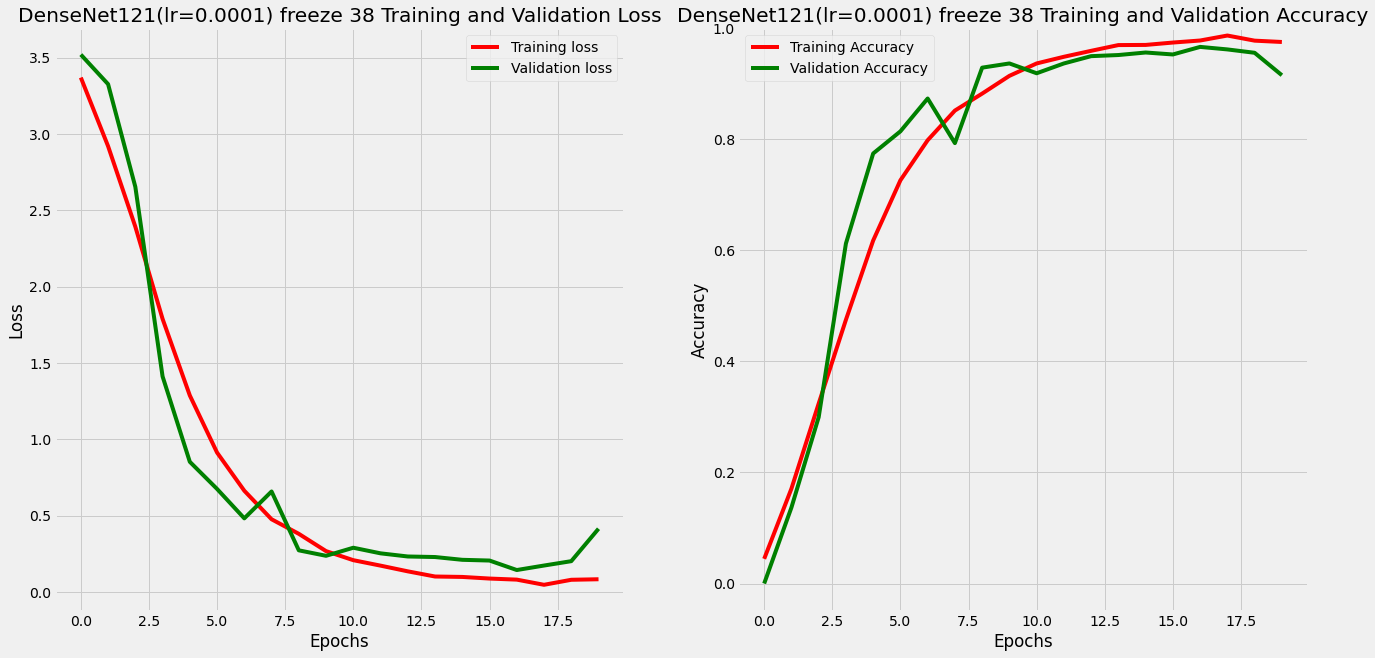

In [ ]:
# Visualization
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(history.history["loss"], 'r', label='Training loss')
axes[0].plot(history.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('ResNet50 Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
plt.ylim(-0.05,1.0)
axes[1].plot (history.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (history.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('ResNet50 Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/ResNet50.jpg")